# Monte Carlo Method
### Why?
Recall from the previous Notebook we ended with asking why we bother running simulations that approach the mean.

What we want to do is advise on *all* outcomes as well as their likelihood. Calculating this when analyzing multiple names with varying degrees of certainty would quickly become complicated. Additionally we would only be able to provide a single-point estimate along with a confidence interval.

### Implementation

In [1]:
import numpy as np
from scipy import stats
with open('data/beta_params.npy', "rb") as fp:
    beta_params = np.load(fp)

def make_beta_distribution(count, prior):
    if prior:
        a, b = get_beta_params(*prior)
    else:
        a, b= 1, 1
        
    n_male, n_female = count
    a += n_female
    b += n_male
    return stats.beta(a, b)
        
def get_beta_params(x, y):
    ci_array = np.asarray(beta_params[:, 2:])
    val_array = np.array([x, y]).reshape(1, 2)
    idx_2d = np.abs(ci_array - val_array)
    # sum the differences
    idx = idx_2d.sum(axis=1)
    alpha, beta, ci_95_min, ci_95_max = beta_params[idx.argmin()]
    return alpha, beta
        

def make_name_simulation(prob_interval, n_trials):
    
    prob_min, prob_max = prob_interval
    min_result = np.random.binomial(1, prob_min, size=n_trials // 2)
    max_result = np.random.binomial(1, prob_max, size=n_trials // 2)
    results = np.concatenate([min_result, max_result])
    np.random.shuffle(results)
    return results

def simulate(count, prior, n_trials):
    beta_dist = make_beta_distribution(count, prior)
    prob_int = beta_dist.interval(0.95)
    result = make_name_simulation(prob_int, n_trials)
    return result

def simulate_many(counts, prior=None, n_trials=50000):
    outcomes = []
    for count in counts:
        outcomes.append(simulate(count, prior, n_trials))
        
    # make large array where each column represents 1 trial and 1 row represents one name_count
    return np.vstack(outcomes)



Below we run several potential scenarios

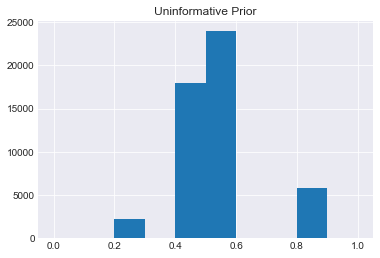

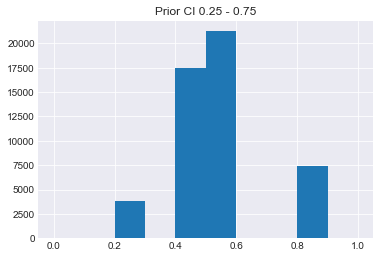

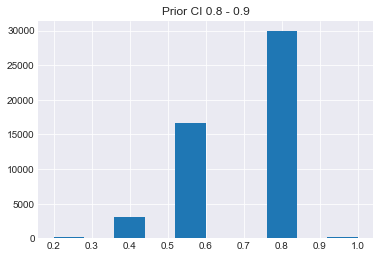

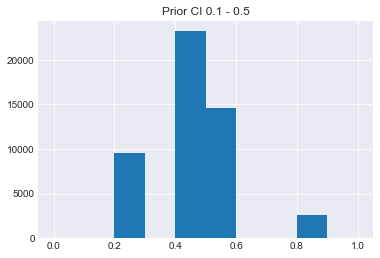

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
from itertools import product

name_counts = [(5, 0),
               (700000, 4000),
               (1200, 480000),
               (1, 18),
               (1, 2)]

priors = [None, (0.25, 0.75), (0.8, 0.9), (0.1, 0.5)]

for x, y in product([name_counts], priors):
    r = simulate_many(counts=x, prior=y)
    plt.figure()
    plt.hist(r.mean(axis=0))
    if not y:
        plt.title("Uninformative Prior")
    else:
        plt.title("Prior CI {} - {}".format(*y))
    plt.show()
    

### Unknown Names

As we know, there is an incredible diversity of first names. When analyzing a name set we are likely to encounter situations where we do not have records for some of these names.

Rather than exclude these from analysis, we simply pass a count of (0, 0) to summarize. The result is that for an unknown prior, these names are equally likely to return male or female.
When a prior is known, the likelihood is a reflection of the prior.  

 


In [3]:
# helper function to generate a large, random name set
def make_random_count():
    total_count = np.random.randint(1, 100000)
    prob = np.random.choice([np.random.beta(30, 5), np.random.beta(5, 30)])
    n_female = np.random.binomial(total_count, prob, 1)
    n_male = total_count - n_female
    return n_male[0], n_female[0]

# helper function to introduce unknown records into a name set at a given rate
def add_unknowns(names, r_unknown):
    if r_unknown <= 0:
        return names
    n_unknown = int(len(names) * r_unknown)
    unknowns = [(0, 0) for i in range(n_unknown)]
    names.extend(unknowns)
    np.random.shuffle(names)
    return names


In [4]:

n_records = [100, 250, 1000]
r_unknowns = [0, 0.05, 0.1, 0.5]
priors = [None, (0.4, 0.6)]

params = list(product(n_records, r_unknowns, priors))
random_names = [make_random_count() for i in range(10000)]


hist_results = []
for i, (sample_size, ratio_unknown, pop_prior) in enumerate(params):
    
    sample_names = random_names[:sample_size]
    sample_names = add_unknowns(sample_names, ratio_unknown)
    
    results = simulate_many(sample_names, prior=pop_prior, n_trials=10000).mean(axis=0)
    hist_results.append(results)


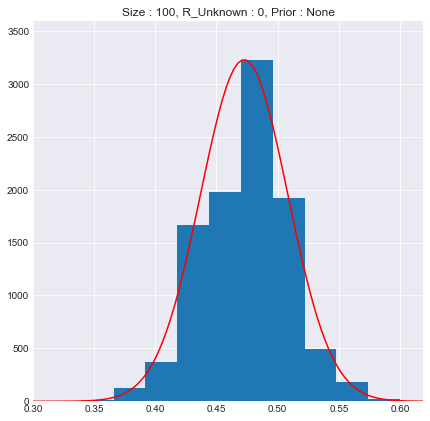

In [5]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')
from IPython.display import HTML

y_max = np.array([np.histogram(r)[0].max() for r in hist_results]).max()
x_min = np.array([np.histogram(r)[1].min() for r in hist_results]).min()
x_max = np.array([np.histogram(r)[1].max() for r in hist_results]).max()

def plot_hist(i, hist_results, params, *args):
    plt.cla()
    plt.xlim(x_min, x_max)
    plt.ylim(0, y_max)
    p = params[i]
    data = hist_results[i]
    mu, sigma = stats.norm.fit(data)
    dist = stats.norm(loc=mu, scale=sigma)
    x_range = np.linspace(x_min, x_max, 100)
    pdf = np.array([dist.pdf(i) for i in x_range])
    
    scaler_max = np.histogram(data)[0].max()
    scaler = MinMaxScaler(feature_range=(0, scaler_max))
    scaled_pdf = scaler.fit_transform(pdf.reshape(-1, 1))
    
    prior_text = "None" if not p[-1] else "{} - {}".format(*p[-1])
    plt.title("Size : {}, R_Unknown : {}, Prior : {}".format(p[0], p[1], prior_text))
    h = plt.hist(data)
    l = plt.plot(x_range, scaled_pdf, c='r')
    return h, l
    
fig = plt.figure(figsize=(7, 7))
plt.xlim(x_min, x_max)
plt.ylim(0, y_max)
hist = plt.hist(hist_results[0])


hist_animation = FuncAnimation(fig, plot_hist, frames=len(hist_results),
                                         fargs=(hist_results,params,), interval=1000)
HTML(hist_animation.to_jshtml())

![Samples](https://raw.githubusercontent.com/estasney/PercyNB/master/notebooks/data/samples.gif)